[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nguyenphuvinhtoan/SpecializedProject_HK231/blob/main/LIP.ipynb)

# Mô tả chung về tập LIP
1. Link tải dataset gốc: https://drive.google.com/drive/folders/1ZjNrTb7T_SsOdck76qDcd5OHkFEU0C6Q
2. Mô tả:
- Các hình ảnh trong tập LIP được crop về dạng person instance từ tập Microsoft COCO training và validation.
- Tập dữ liệu có 19 label bao gồm bộ phận cơ thể người và trang phục.
- Tập dữ liệu này bao gồm 50.462 hình ảnh con người với các chú thích theo pixel của 19 bộ phận theo ngữ nghĩa (semantic parts) và 16 khớp cơ thể (body joints) bao gồm:
    + 19.081 ảnh đầy đủ cơ thể - full-body
    + 403 ảnh phần dưới cơ thể - lower-body
    + 3.386 ảnh thiếu đầu - head-missing
    + 2.778 ảnh chụp từ sau - back-view
    + 21.028 ảnh bị che khuất - occlusions)
Được chú thích với human parsing và pose labels. (Ta sẽ chú trọng đến human parsing hơn trong scope bài này)
- 50.462 ảnh được chia thành 3 tập với phân bố như sau:
    + Training: 30.462 hình
    + Validation: 10.000 hình
    + Test: 10.000 hình

- Hình ảnh minh hoạ:
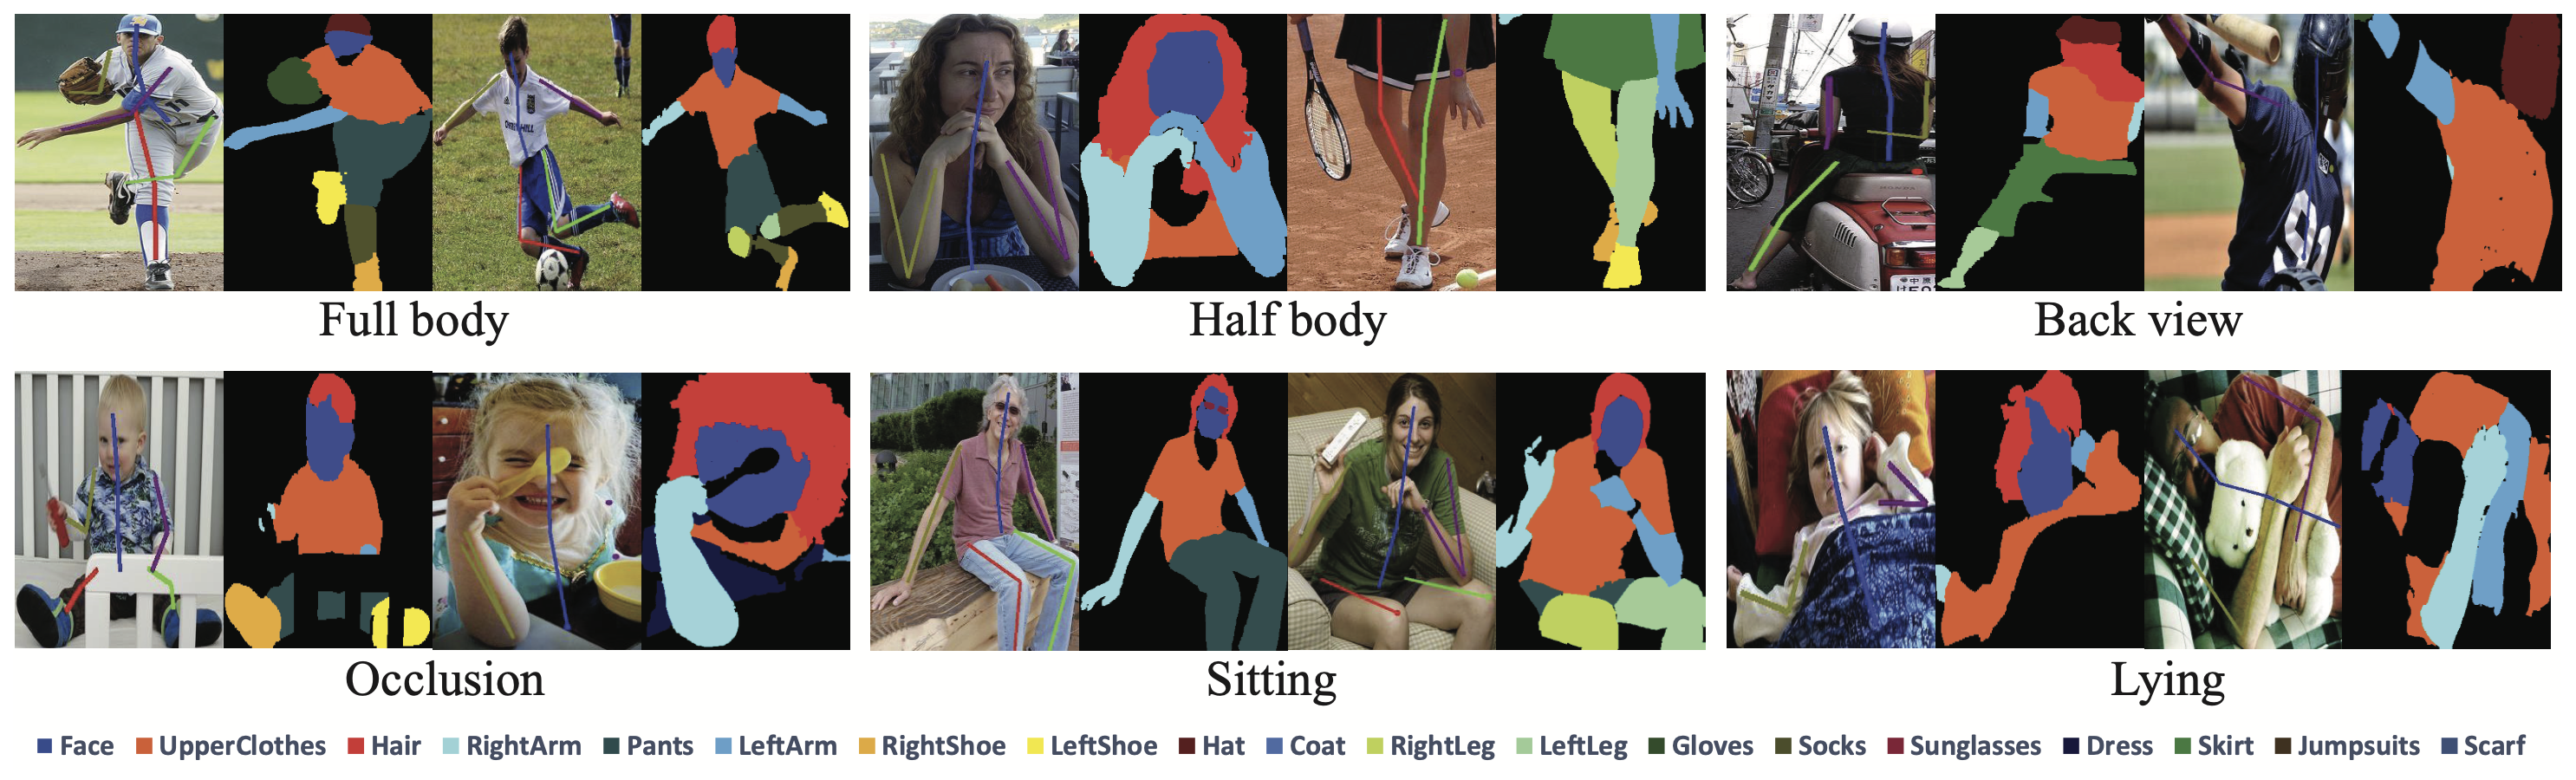

# 0. Import thư viện

In [ ]:
# import tensorflow as tf
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(threshold=np.inf)

In [ ]:
# Khai báo phổ màu cho label (BGR)
label_colours = [(0,0,0)
                # 0=Background
                ,(128,0,0),(255,0,0),(0,85,0),(170,0,51),(255,85,0)
                # 1=Hat,  2=Hair,    3=Glove, 4=Sunglasses, 5=UpperClothes
                ,(0,0,85),(0,119,221),(85,85,0),(0,85,85),(85,51,0)
                # 6=Dress, 7=Coat, 8=Socks, 9=Pants, 10=Jumpsuits
                ,(52,86,128),(0,128,0),(0,0,255),(51,170,221),(0,255,255)
                # 11=Scarf, 12=Skirt, 13=Face, 14=LeftArm, 15=RightArm
                ,(85,255,170),(170,255,85),(255,255,0),(255,170,0)]
                # 16=LeftLeg, 17=RightLeg, 18=LeftShoe, 19=RightShoe
# Turn this into BGR
for i, color in enumerate(label_colours):
  label_colours[i] = (color[2], color[1], color[0])
# Tên của mỗi label
label_names = ["0-Background", "1-Hat", "2-Hair", "3-Glove", "4-Sunglasses",
               "5-UpperClothes", "6-Dress", "7-Coat", "8-Socks", "9-Pants", "10-Jumpsuits",
               "11-Scarf", "12-Skirt", "13-Face", "14-LeftArm", "15-RightArm", "16-LeftLeg",
               "17-RightLeg", "18-LeftShoe", "19-RightShoe"]

# 1. Code Import data từ kaggle

## 1.0. Set up Kaggle API

Nếu bạn không quen với việc lấy Kaggle API để có thể tải về tập dữ liệu, bạn có thể tham khảo tại đây: https://www.kaggle.com/discussions/general/74235

In [ ]:
# install the newest version of Kaggle API
! pip install --upgrade --force-reinstall --no-deps kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.16-py3-none-any.whl size=110683 sha256=ff4134c83720db6c31a8f94d3f2efb4022c76f11c5ff3bd6aa29162efd4a186c
  Stored in directory: /root/.cache/pip/wheels/43/4b/fb/736478af5e8004810081a06259f9aa2f7c3329fc5d03c2c412
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16


In [ ]:
# create .kaggle folder in the root folder
! mkdir ~/.kaggle
# copy the kaggle.json file that have been updated to the .kaggle folder
! cp kaggle.json ~/.kaggle/kaggle.json
# remove the kaggle.json in the current directory
! rm kaggle.json
# for security to make sure only you can access the .json credential file
! chmod 600 ~/.kaggle/kaggle.json

## 1.1. Imoprt từ Kaggle của Toàn

In [ ]:
# Download LIP_Label from Kaggle
! kaggle datasets download -d nguyenphuvinhtoan/lip-trainval-label

100% 89.0M/89.0M [00:00<00:00, 142MB/s] 
100% 89.0M/89.0M [00:00<00:00, 114MB/s]


In [ ]:
!unzip -qq lip-trainval-label.zip

In [ ]:
!rm -rf lip-trainval-label.zip

# 2. Tạo đối tượng chứa các ảnh cần xử lí

In [ ]:
# Tạo list các ảnh
train_label_paths = []
val_label_paths = []
train_folder_path = "/content/train_segmentations"
val_folder_path = "/content/val_segmentations"
for file in os.listdir(train_folder_path):
    train_label_paths.append(os.path.join(train_folder_path, file))
for file in os.listdir(val_folder_path):
    val_label_paths.append(os.path.join(val_folder_path, file))

In [ ]:
print(len(train_label_paths))
print(len(val_label_paths))

30462
10000


# Train_LIP

## 3. Đọc dữ liệu ảnh vào Train

In [ ]:
# Đọc dữ liệu ảnh train
train_image = [cv2.imread(train_path, cv2.IMREAD_GRAYSCALE) for train_path in train_label_paths]

In [ ]:
print(len(train_image))

30462


 ## 4. Thực hiện thống kê Train

### 4.1. Thống kê kích thước ảnh

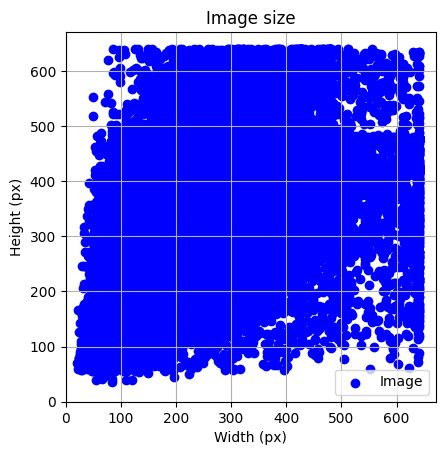

In [ ]:
# Tạo list là data để vẽ scatter plot (x, y)
data01 = [(image.shape[1], image.shape[0]) for image in train_image]
x01 = [point[0] for point in data01]
y01 = [point[1] for point in data01]
# Tạo plot
plt.scatter(x01, y01, label="Image", color="blue")
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.xlim(left=0)
plt.ylim(bottom=0)
# Đánh tên cho trục
plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.title("Image size")
plt.legend(loc="best")
# Hiện plot
plt.show()

In [ ]:
# Đổi biểu đồ scatter thành biểu đồ heatmap
# Chuẩn bị data để vẽ biểu đồ
x01_div50 = [x // 50 for x in x01]
y01_div50 = [y // 50 for y in y01]
data01_div50 = np.zeros((max(y01_div50) + 1, max(x01_div50) + 1))
for i in range(len(x01_div50)):
  data01_div50[y01_div50[i]][x01_div50[i]] += 1
x01_div50_labels = [(i+1)*50 for i in range(max(x01_div50) + 1)]
y01_div50_labels = [(i+1)*50 for i in range(max(y01_div50) + 1)]

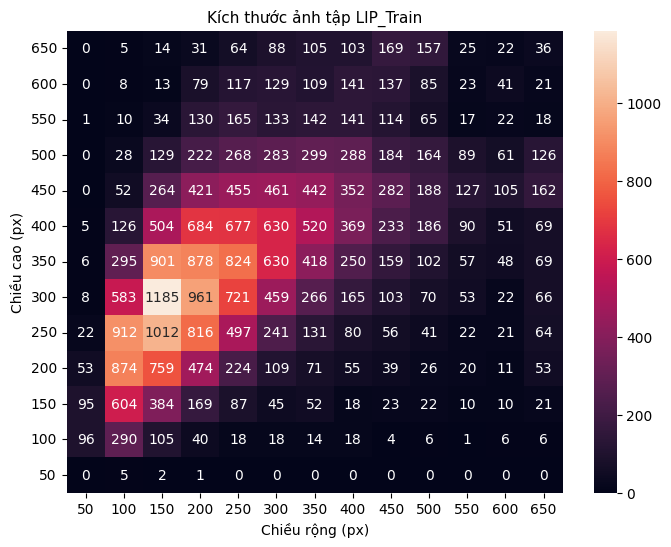

In [ ]:
plt.figure(figsize=(8,6))
# Vẽ biểu đồ heatmap
hm = sns.heatmap(data=data01_div50, xticklabels=x01_div50_labels,
                 yticklabels=y01_div50_labels, annot=True, fmt='g')
hm.invert_yaxis()
# Đánh tên cho trục
plt.xlabel("Chiều rộng (px)", fontsize=10)
plt.ylabel("Chiều cao (px)", fontsize=10)
plt.title("Kích thước ảnh tập LIP_Train", fontsize=11)
plt.yticks(rotation=0)
# Hiện biểu đồ
plt.show()

Các giá trị thống kê

In [ ]:
print("Width: [%d, %d]" % (min(x01), max(x01)))
print("Width Mean: %d" % (np.mean(np.array(x01))))
print("Width Variance: %d" % (np.var(np.array(x01))))
print("Width STD: %d" % (np.std(np.array(x01))))
print("Height: [%d, %d]" % (min(y01), max(y01)))
print("Height Mean: %d" % (np.mean(np.array(y01))))
print("Height Variance: %d" % (np.var(np.array(y01))))
print("Height STD: %d" % (np.std(np.array(y01))))


Width: [21, 640]
Width Mean: 240
Width Variance: 18867
Width STD: 137
Height: [36, 640]
Height Mean: 325
Height Variance: 15432
Height STD: 124


### 4.2 Thống kê số ảnh mỗi label

In [ ]:
# Find out semantic part labels in each image
image_unique_value = [np.unique(image) for image in train_image]
image_unique_value_count = [len(uv) for uv in image_unique_value]

# Đếm số ảnh có label được nhắc
img_per_label_count = [0] * len(label_names)
for image_uv in image_unique_value:
  for uv in image_uv:
    img_per_label_count[uv] += 1
# Phân loại màu cho tên label
label_is_human_part = [False, False, True, False, False, False, False, False,
                       False, False, False, False, False, True, True, True,
                       False, False, True, True]
plt02_color = [("red" if is_human_part else "blue") for is_human_part in label_is_human_part]

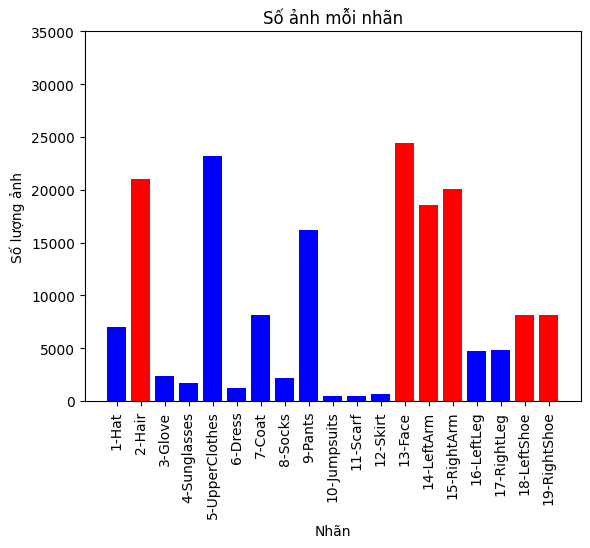

In [ ]:
# Tạo column chart
plt.bar(label_names[1:], img_per_label_count[1:], color=plt02_color[1:])
# Đánh tên cho trục
plt.xlabel("Nhãn")
plt.ylabel("Số lượng ảnh")
plt.title("Số ảnh mỗi nhãn")
plt.xticks(rotation=90)
plt.ylim(0,35000)
# Hiện plot
plt.show()

In [ ]:
# Tạo column chart được sắp xếp lại các cột theo nhóm màu
label_names_02, img_per_label_count_02, plt02_color_02 = ([], [], [])
sorter_idx = [10,11,12,6,4,8,3,16,17,1,7,9,5,13,2,15,14,19,18]
for i in range(len(sorter_idx)):
  label_names_02.append(label_names[sorter_idx[i]])
  img_per_label_count_02.append(img_per_label_count[sorter_idx[i]])
  plt02_color_02.append(plt02_color[sorter_idx[i]])

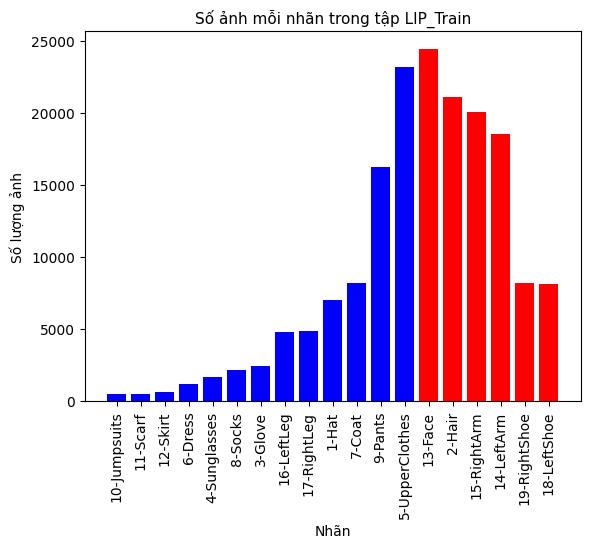

In [ ]:
# Tạo column chart
plt.bar(label_names_02, img_per_label_count_02, color=plt02_color_02)
# Đánh tên cho trục
plt.xlabel("Nhãn")
plt.ylabel("Số lượng ảnh")
plt.title("Số ảnh mỗi nhãn trong tập LIP_Train", fontsize=11)
plt.xticks(rotation=90)
# plt.ylim(0,35000)
# Hiện plot
plt.show()

Thống kê theo tổng các nhãn

In [ ]:
# Không tính background
print(f"Miền giá trị: [{min(img_per_label_count[1:])}, {max(img_per_label_count[1:])}]")
print("Giá trị trung bình: %d" % (np.mean(np.array(img_per_label_count[1:]))))
print("Giá trị Variance: %d" % (np.var(np.array(img_per_label_count[1:]))))
print("Giá trị STD: %d" % (np.std(np.array(img_per_label_count[1:]))))

Miền giá trị: [455, 24418]
Giá trị trung bình: 9135
Giá trị Variance: 68908667
Giá trị STD: 8301


Tách đôi việc đếm số hình cho nhãn bộ phận người và nhãn quần áo

In [ ]:
img_per_label_is_human = []
img_per_label_not_human = []
for i, img_per_label in enumerate(img_per_label_count):
  if label_is_human_part[i]:
    img_per_label_is_human.append(img_per_label)
  else:
    img_per_label_not_human.append(img_per_label)

Thống kê theo nhãn bộ phận người

In [ ]:
print(f"Miền giá trị: [{min(img_per_label_is_human)}, {max(img_per_label_is_human)}]")
print("Giá trị trung bình: %d" % (np.mean(np.array(img_per_label_is_human))))
print("Giá trị Variance: %d" % (np.var(np.array(img_per_label_is_human))))
print("Giá trị STD: %d" % (np.std(np.array(img_per_label_is_human))))

Miền giá trị: [8126, 24418]
Giá trị trung bình: 16722
Giá trị Variance: 39892533
Giá trị STD: 6316


Thống kê theo nhãn trang phục

In [ ]:
# Không tính background
print(f"Miền giá trị: [{min(img_per_label_not_human[1:])}, {max(img_per_label_not_human[1:])}]")
print("Giá trị trung bình: %d" % (np.mean(np.array(img_per_label_not_human[1:]))))
print("Giá trị Variance: %d" % (np.var(np.array(img_per_label_not_human[1:]))))
print("Giá trị STD: %d" % (np.std(np.array(img_per_label_not_human[1:]))))

Miền giá trị: [455, 23165]
Giá trị trung bình: 5634
Giá trị Variance: 43471720
Giá trị STD: 6593


### 4.3 Thống kê số lượng ảnh có số lượng label tương ứng

In [ ]:
# Không tính background
label_array_uvc_no_bg = []
for i in range(len(image_unique_value_count)):
  label_array_uvc_no_bg.append(image_unique_value_count[i] - 1)
img_count_as_label_amount_no_bg = [0] * len(label_names)
for label_count in label_array_uvc_no_bg:
  img_count_as_label_amount_no_bg[label_count] += 1

In [ ]:
# for i, label_count in enumerate(image_unique_value_count):
#   if label_count == 1: print(i)

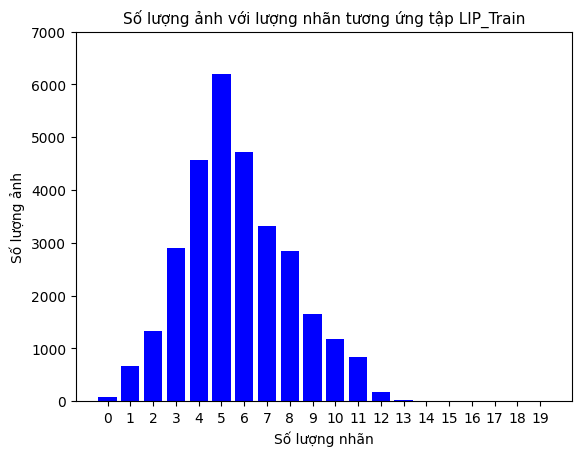

In [ ]:
# Tạo column chart
plt.bar(range(20), img_count_as_label_amount_no_bg, color="blue")
plt.xticks(range(20))
plt.ylim(0,7000)
# Đánh tên cho trục
plt.xlabel("Số lượng nhãn")
plt.ylabel("Số lượng ảnh")
plt.title("Số lượng ảnh với lượng nhãn tương ứng tập LIP_Train", fontsize=11)

# Hiện plot
plt.show()

Chỉ số thống kê

In [ ]:
# Thống kê dựa trên số lượng nhãn
print(f"Range: [{min(label_array_uvc_no_bg)}, {max(label_array_uvc_no_bg)}]")
print("Mean: %0.1f" % (np.mean(np.array(label_array_uvc_no_bg))))
print("Variance: %0.1f" % (np.var(np.array(label_array_uvc_no_bg))))
print("STD: %0.1f" % (np.std(np.array(label_array_uvc_no_bg))))

Range: [0, 15]
Mean: 5.7
Variance: 5.4
STD: 2.3


### 4.4. Thống kê tỉ lệ nhãn bộ phận người và nhãn trang phục trên mỗi ảnh

In [ ]:
# Chuẩn bị data
human_label_per_img = [0] * len(train_image)
non_human_label_per_img = [0] * len(train_image)
for i, label_array in enumerate(image_unique_value):
  for label_idx in label_array:
    if label_is_human_part[label_idx]:
      human_label_per_img[i] += 1
    else:
      non_human_label_per_img[i] += 1
# Không tính background nên trừ bớt 1
for i in range(len(non_human_label_per_img)):
  non_human_label_per_img[i] -= 1
# Tạo ndarray data
data02 = np.zeros((max(non_human_label_per_img)+1, max(human_label_per_img)+1))
for i in range(len(human_label_per_img)):
  data02[non_human_label_per_img[i]][human_label_per_img[i]] += 1

In [ ]:
sum(sum(data02))

30462.0

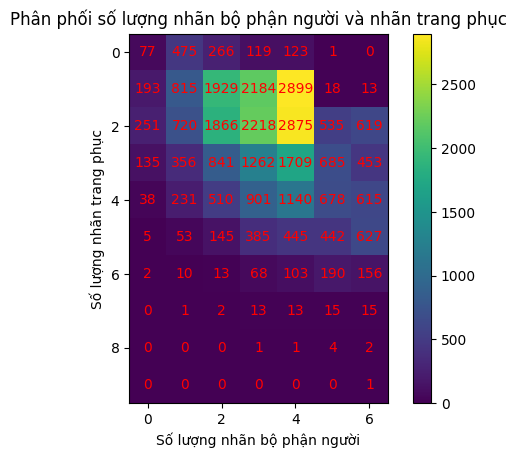

In [ ]:
# Tạo plot
plt.imshow(data02, interpolation='nearest')
plt.colorbar()
# Đánh tên cho trục
plt.xlabel("Số lượng nhãn bộ phận người")
plt.ylabel("Số lượng nhãn trang phục")
plt.title("Phân phối số lượng nhãn bộ phận người và nhãn trang phục")
# Đánh số lên heatmap
for i in range(data02.shape[0]):
  for j in range(data02.shape[1]):
    plt.annotate(str(int(data02[i][j])), xy=(j, i),
                     ha='center', va='center', color='red')
# Hiện plot
plt.show()

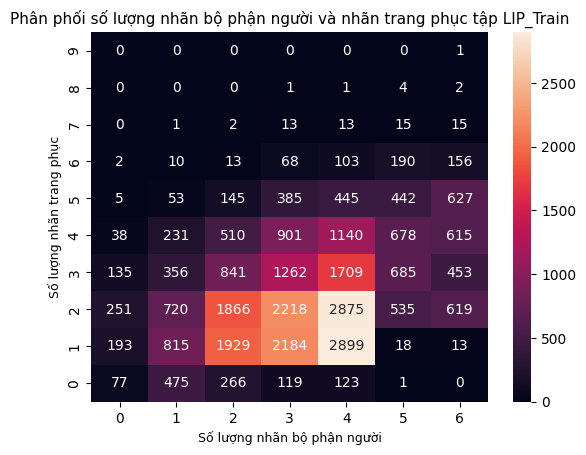

In [ ]:
hm = sns.heatmap(data=data02, annot=True, fmt='g')
hm.invert_yaxis()
# Đánh tên cho trục
plt.xlabel("Số lượng nhãn bộ phận người", fontsize=9)
plt.ylabel("Số lượng nhãn trang phục", fontsize=9)
plt.title("Phân phối số lượng nhãn bộ phận người và nhãn trang phục tập LIP_Train", fontsize=11)
# Hiện biểu đồ
plt.show()

Thống kê số nhãn

In [ ]:
# Thống kê về số nhãn bộ phận người mỗi ảnh
print("Range: [%d, %d]" % (min(human_label_per_img), max(human_label_per_img)))
print("Mean: %.1f" % (np.mean(np.array(human_label_per_img))))
print("Variance: %.1f" % (np.var(np.array(human_label_per_img))))
print("STD: %.1f" % (np.std(np.array(human_label_per_img))))
# Thống kê về số nhãn quần áo mỗi ảnh
print("Range: [%d, %d]" % (min(non_human_label_per_img), max(non_human_label_per_img)))
print("Mean: %.1f" % (np.mean(np.array(non_human_label_per_img))))
print("Variance: %.1f" % (np.var(np.array(non_human_label_per_img))))
print("STD: %.1f" % (np.std(np.array(non_human_label_per_img))))

Range: [0, 6]
Mean: 3.3
Variance: 2.0
STD: 1.4
Range: [0, 9]
Mean: 2.4
Variance: 1.9
STD: 1.4


In [ ]:
data02

array([[7.700e+01, 4.750e+02, 2.660e+02, 1.190e+02, 1.230e+02, 1.000e+00,
        0.000e+00],
       [1.930e+02, 8.150e+02, 1.929e+03, 2.184e+03, 2.899e+03, 1.800e+01,
        1.300e+01],
       [2.510e+02, 7.200e+02, 1.866e+03, 2.218e+03, 2.875e+03, 5.350e+02,
        6.190e+02],
       [1.350e+02, 3.560e+02, 8.410e+02, 1.262e+03, 1.709e+03, 6.850e+02,
        4.530e+02],
       [3.800e+01, 2.310e+02, 5.100e+02, 9.010e+02, 1.140e+03, 6.780e+02,
        6.150e+02],
       [5.000e+00, 5.300e+01, 1.450e+02, 3.850e+02, 4.450e+02, 4.420e+02,
        6.270e+02],
       [2.000e+00, 1.000e+01, 1.300e+01, 6.800e+01, 1.030e+02, 1.900e+02,
        1.560e+02],
       [0.000e+00, 1.000e+00, 2.000e+00, 1.300e+01, 1.300e+01, 1.500e+01,
        1.500e+01],
       [0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 4.000e+00,
        2.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00]])

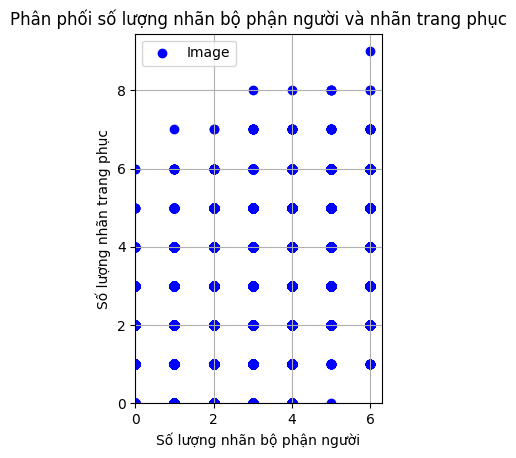

In [ ]:
# Tạo plot
plt.scatter(human_label_per_img, non_human_label_per_img, label="Image", color="blue")
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.xlim(left=0)
plt.ylim(bottom=0)
# Đánh tên cho trục
plt.xlabel("Số lượng nhãn bộ phận người")
plt.ylabel("Số lượng nhãn trang phục")
plt.title("Phân phối số lượng nhãn bộ phận người và nhãn trang phục")
plt.legend(loc="best")
# Hiện plot
plt.show()

# Val_LIP

## 3. Đọc dữ liệu ảnh vào Val

In [ ]:
# Đọc dữ liệu ảnh validation
val_image = [cv2.imread(val_path, cv2.IMREAD_GRAYSCALE) for val_path in val_label_paths]

In [ ]:
print(len(val_image))

10000


 ## 4. Thực hiện thống kê Val

### 4.1. Thống kê kích thước ảnh

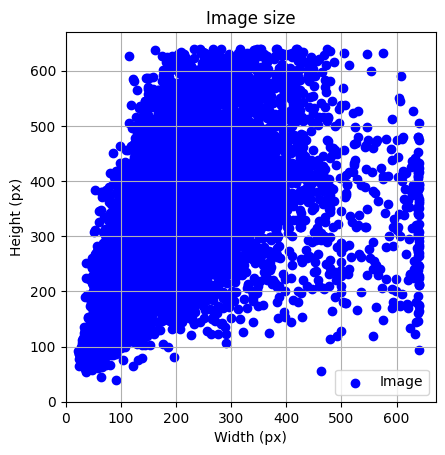

In [ ]:
# Tạo list là data để vẽ scatter plot (x, y)
data01 = [(image.shape[1], image.shape[0]) for image in val_image]
x01 = [point[0] for point in data01]
y01 = [point[1] for point in data01]
# Tạo plot
plt.scatter(x01, y01, label="Image", color="blue")
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.xlim(left=0)
plt.ylim(bottom=0)
# Đánh tên cho trục
plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.title("Image size")
plt.legend(loc="best")
# Hiện plot
plt.show()

In [ ]:
# Đổi biểu đồ scatter thành biểu đồ heatmap
# Chuẩn bị data để vẽ biểu đồ
x01_div50 = [x // 50 for x in x01]
y01_div50 = [y // 50 for y in y01]
data01_div50 = np.zeros((max(y01_div50) + 1, max(x01_div50) + 1))
for i in range(len(x01_div50)):
  data01_div50[y01_div50[i]][x01_div50[i]] += 1
x01_div50_labels = [(i+1)*50 for i in range(max(x01_div50) + 1)]
y01_div50_labels = [(i+1)*50 for i in range(max(y01_div50) + 1)]

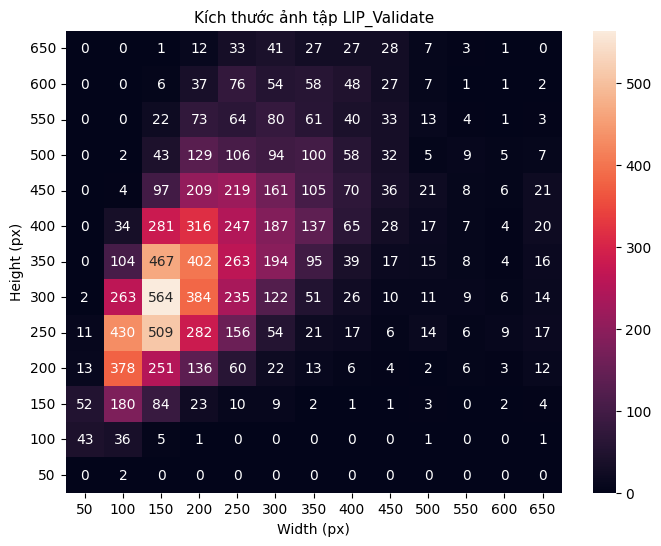

In [ ]:
plt.figure(figsize=(8,6))
# Vẽ biểu đồ heatmap
hm = sns.heatmap(data=data01_div50, xticklabels=x01_div50_labels,
                 yticklabels=y01_div50_labels, annot=True, fmt='g')
hm.invert_yaxis()
# Đánh tên cho trục
plt.xlabel("Width (px)", fontsize=10)
plt.ylabel("Height (px)", fontsize=10)
plt.title("Kích thước ảnh tập LIP_Validate", fontsize=11)
plt.yticks(rotation=0)
# Hiện biểu đồ
plt.show()

Các giá trị thống kê

In [ ]:
print("Width: [%d, %d]" % (min(x01), max(x01)))
print("Width Mean: %d" % (np.mean(np.array(x01))))
print("Width Variance: %d" % (np.var(np.array(x01))))
print("Width STD: %d" % (np.std(np.array(x01))))
print("Height: [%d, %d]" % (min(y01), max(y01)))
print("Height Mean: %d" % (np.mean(np.array(y01))))
print("Height Variance: %d" % (np.var(np.array(y01))))
print("Height STD: %d" % (np.std(np.array(y01))))


Width: [22, 640]
Width Mean: 200
Width Variance: 12187
Width STD: 110
Height: [40, 640]
Height Mean: 323
Height Variance: 13629
Height STD: 116


### 4.2 Thống kê số ảnh mỗi label

In [ ]:
# Find out semantic part labels in each image
image_unique_value = [np.unique(image) for image in val_image]
image_unique_value_count = [len(uv) for uv in image_unique_value]

# Đếm số ảnh có label được nhắc
img_per_label_count = [0] * len(label_names)
for image_uv in image_unique_value:
  for uv in image_uv:
    img_per_label_count[uv] += 1
# Phân loại màu cho tên label
label_is_human_part = [False, False, True, False, False, False, False, False,
                       False, False, False, False, False, True, True, True,
                       False, False, True, True]
plt02_color = [("red" if is_human_part else "blue") for is_human_part in label_is_human_part]

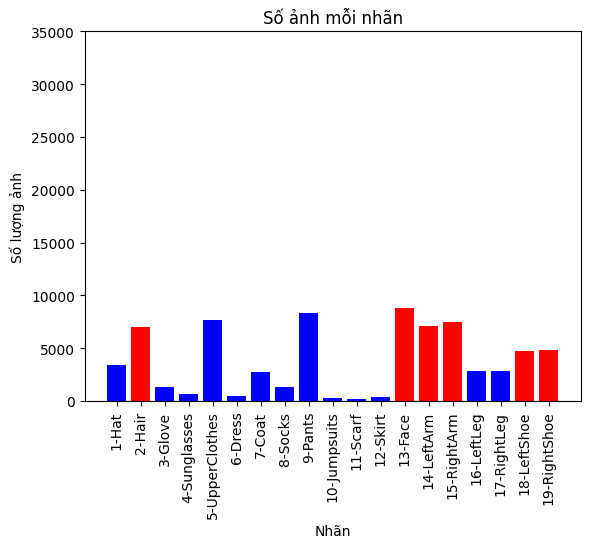

In [ ]:
# Tạo column chart
plt.bar(label_names[1:], img_per_label_count[1:], color=plt02_color[1:])
# Đánh tên cho trục
plt.xlabel("Nhãn")
plt.ylabel("Số lượng ảnh")
plt.title("Số ảnh mỗi nhãn")
plt.xticks(rotation=90)
plt.ylim(0,35000)
# Hiện plot
plt.show()

In [ ]:
# Tạo column chart được sắp xếp lại các cột theo nhóm màu
label_names_02, img_per_label_count_02, plt02_color_02 = ([], [], [])
sorter_idx = [10,11,12,6,4,8,3,16,17,1,7,9,5,13,2,15,14,19,18]
for i in range(len(sorter_idx)):
  label_names_02.append(label_names[sorter_idx[i]])
  img_per_label_count_02.append(img_per_label_count[sorter_idx[i]])
  plt02_color_02.append(plt02_color[sorter_idx[i]])

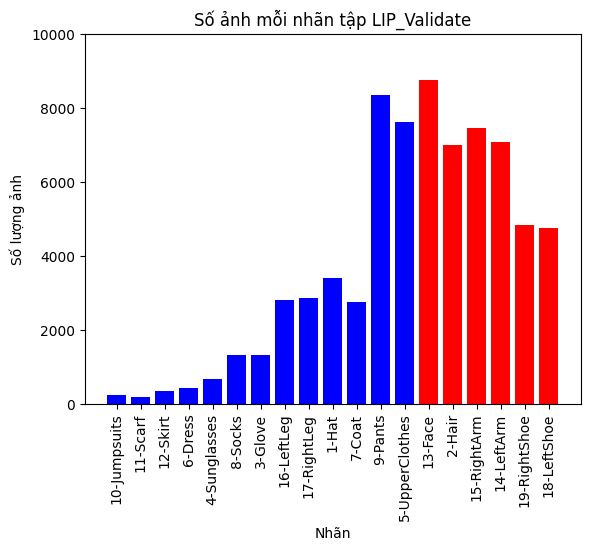

In [ ]:
# Tạo column chart
plt.bar(label_names_02, img_per_label_count_02, color=plt02_color_02)
# Đánh tên cho trục
plt.xlabel("Nhãn")
plt.ylabel("Số lượng ảnh")
plt.title("Số ảnh mỗi nhãn tập LIP_Validate")
plt.xticks(rotation=90)
plt.ylim(0,10000)
# Hiện plot
plt.show()

Thống kê theo tổng các nhãn

In [ ]:
# Không tính background
print(f"Miền giá trị: [{min(img_per_label_count[1:])}, {max(img_per_label_count[1:])}]")
print("Giá trị trung bình: %d" % (np.mean(np.array(img_per_label_count[1:]))))
print("Giá trị Variance: %d" % (np.var(np.array(img_per_label_count[1:]))))
print("Giá trị STD: %d" % (np.std(np.array(img_per_label_count[1:]))))

Miền giá trị: [200, 8765]
Giá trị trung bình: 3807
Giá trị Variance: 8977156
Giá trị STD: 2996


Tách đôi việc đếm số hình cho nhãn bộ phận người và nhãn quần áo

In [ ]:
img_per_label_is_human = []
img_per_label_not_human = []
for i, img_per_label in enumerate(img_per_label_count):
  if label_is_human_part[i]:
    img_per_label_is_human.append(img_per_label)
  else:
    img_per_label_not_human.append(img_per_label)

Thống kê theo nhãn bộ phận người

In [ ]:
print(f"Miền giá trị: [{min(img_per_label_is_human)}, {max(img_per_label_is_human)}]")
print("Giá trị trung bình: %d" % (np.mean(np.array(img_per_label_is_human))))
print("Giá trị Variance: %d" % (np.var(np.array(img_per_label_is_human))))
print("Giá trị STD: %d" % (np.std(np.array(img_per_label_is_human))))

Miền giá trị: [4769, 8765]
Giá trị trung bình: 6657
Giá trị Variance: 2039303
Giá trị STD: 1428


Thống kê theo nhãn trang phục

In [ ]:
# Không tính background
print(f"Miền giá trị: [{min(img_per_label_not_human[1:])}, {max(img_per_label_not_human[1:])}]")
print("Giá trị trung bình: %d" % (np.mean(np.array(img_per_label_not_human[1:]))))
print("Giá trị Variance: %d" % (np.var(np.array(img_per_label_not_human[1:]))))
print("Giá trị STD: %d" % (np.std(np.array(img_per_label_not_human[1:]))))

Miền giá trị: [200, 8371]
Giá trị trung bình: 2491
Giá trị Variance: 6700564
Giá trị STD: 2588


### 4.3 Thống kê số lượng ảnh có số lượng label tương ứng

In [ ]:
# Không tính background
label_array_uvc_no_bg = []
for i in range(len(image_unique_value_count)):
  label_array_uvc_no_bg.append(image_unique_value_count[i] - 1)
img_count_as_label_amount_no_bg = [0] * len(label_names)
for label_count in label_array_uvc_no_bg:
  img_count_as_label_amount_no_bg[label_count] += 1

In [ ]:
for i, label_count in enumerate(image_unique_value_count):
  if label_count == 1: print(i)

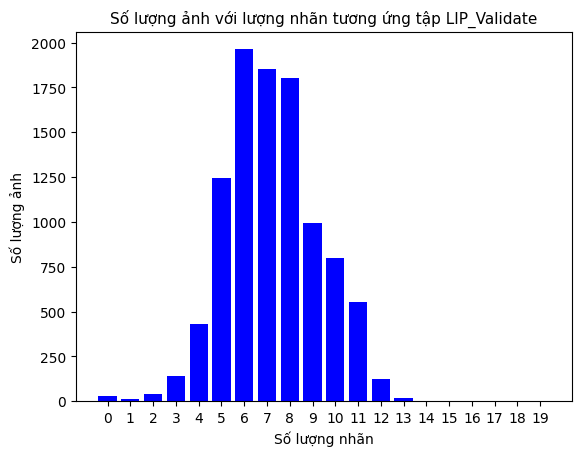

In [ ]:
# Tạo column chart
plt.bar(range(20), img_count_as_label_amount_no_bg, color="blue")
plt.xticks(range(20))
# plt.ylim(0,8000)
# Đánh tên cho trục
plt.xlabel("Số lượng nhãn")
plt.ylabel("Số lượng ảnh")
plt.title("Số lượng ảnh với lượng nhãn tương ứng tập LIP_Validate", fontsize=11)

# Hiện plot
plt.show()

Chỉ số thống kê

In [ ]:
# Thống kê dựa trên số lượng nhãn
print(f"Range: [{min(label_array_uvc_no_bg)}, {max(label_array_uvc_no_bg)}]")
print("Mean: %0.1f" % (np.mean(np.array(label_array_uvc_no_bg))))
print("Variance: %0.1f" % (np.var(np.array(label_array_uvc_no_bg))))
print("STD: %0.1f" % (np.std(np.array(label_array_uvc_no_bg))))

Range: [0, 14]
Mean: 7.2
Variance: 4.1
STD: 2.0


### 4.4. Thống kê tỉ lệ nhãn bộ phận người và nhãn trang phục trên mỗi ảnh

In [ ]:
# Chuẩn bị data
human_label_per_img = [0] * len(val_image)
non_human_label_per_img = [0] * len(val_image)
for i, label_array in enumerate(image_unique_value):
  for label_idx in label_array:
    if label_is_human_part[label_idx]:
      human_label_per_img[i] += 1
    else:
      non_human_label_per_img[i] += 1
# Không tính background nên trừ bớt 1
for i in range(len(non_human_label_per_img)):
  non_human_label_per_img[i] -= 1
# Tạo ndarray data
data02 = np.zeros((max(non_human_label_per_img)+1, max(human_label_per_img)+1))
for i in range(len(human_label_per_img)):
  data02[non_human_label_per_img[i]][human_label_per_img[i]] += 1

In [ ]:
sum(sum(data02))

10000.0

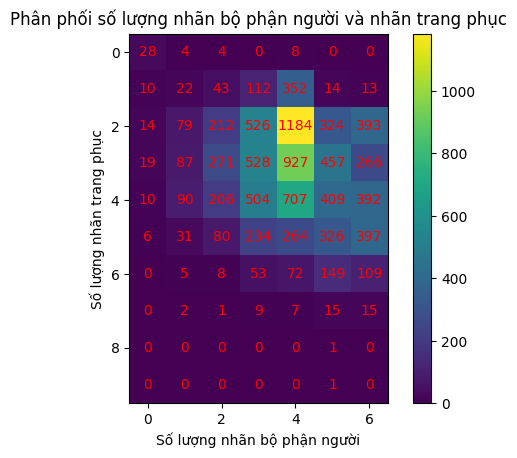

In [ ]:
# Tạo plot
plt.imshow(data02, interpolation='nearest')
plt.colorbar()
# Đánh tên cho trục
plt.xlabel("Số lượng nhãn bộ phận người")
plt.ylabel("Số lượng nhãn trang phục")
plt.title("Phân phối số lượng nhãn bộ phận người và nhãn trang phục")
# Đánh số lên heatmap
for i in range(data02.shape[0]):
  for j in range(data02.shape[1]):
    plt.annotate(str(int(data02[i][j])), xy=(j, i),
                     ha='center', va='center', color='red')
# Hiện plot
plt.show()

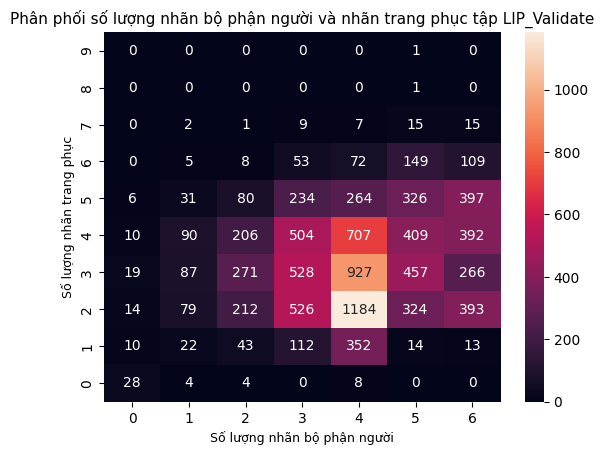

In [ ]:
hm = sns.heatmap(data=data02, annot=True, fmt='g')
hm.invert_yaxis()
# Đánh tên cho trục
plt.xlabel("Số lượng nhãn bộ phận người", fontsize=9)
plt.ylabel("Số lượng nhãn trang phục", fontsize=9)
plt.title("Phân phối số lượng nhãn bộ phận người và nhãn trang phục tập LIP_Validate", fontsize=11)
# Hiện biểu đồ
plt.show()

Thống kê số nhãn

In [ ]:
# Thống kê về số nhãn bộ phận người mỗi ảnh
print("Range: [%d, %d]" % (min(human_label_per_img), max(human_label_per_img)))
print("Mean: %.1f" % (np.mean(np.array(human_label_per_img))))
print("Variance: %.1f" % (np.var(np.array(human_label_per_img))))
print("STD: %.1f" % (np.std(np.array(human_label_per_img))))
# Thống kê về số nhãn quần áo mỗi ảnh
print("Range: [%d, %d]" % (min(non_human_label_per_img), max(non_human_label_per_img)))
print("Mean: %.1f" % (np.mean(np.array(non_human_label_per_img))))
print("Variance: %.1f" % (np.var(np.array(non_human_label_per_img))))
print("STD: %.1f" % (np.std(np.array(non_human_label_per_img))))

Range: [0, 6]
Mean: 4.0
Variance: 1.8
STD: 1.3
Range: [0, 9]
Mean: 3.2
Variance: 1.7
STD: 1.3


In [ ]:
data02

array([[2.800e+01, 4.000e+00, 4.000e+00, 0.000e+00, 8.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+01, 2.200e+01, 4.300e+01, 1.120e+02, 3.520e+02, 1.400e+01,
        1.300e+01],
       [1.400e+01, 7.900e+01, 2.120e+02, 5.260e+02, 1.184e+03, 3.240e+02,
        3.930e+02],
       [1.900e+01, 8.700e+01, 2.710e+02, 5.280e+02, 9.270e+02, 4.570e+02,
        2.660e+02],
       [1.000e+01, 9.000e+01, 2.060e+02, 5.040e+02, 7.070e+02, 4.090e+02,
        3.920e+02],
       [6.000e+00, 3.100e+01, 8.000e+01, 2.340e+02, 2.640e+02, 3.260e+02,
        3.970e+02],
       [0.000e+00, 5.000e+00, 8.000e+00, 5.300e+01, 7.200e+01, 1.490e+02,
        1.090e+02],
       [0.000e+00, 2.000e+00, 1.000e+00, 9.000e+00, 7.000e+00, 1.500e+01,
        1.500e+01],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00]])

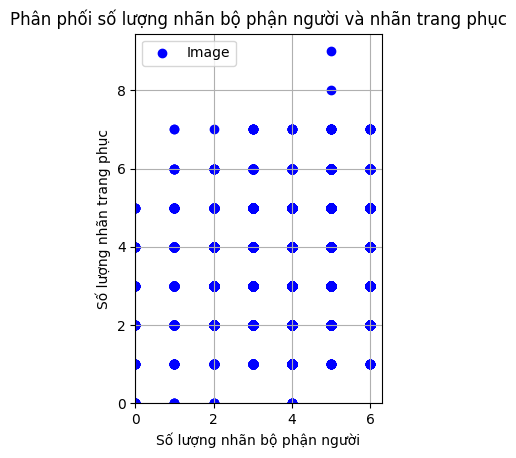

In [ ]:
# Tạo plot
plt.scatter(human_label_per_img, non_human_label_per_img, label="Image", color="blue")
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.xlim(left=0)
plt.ylim(bottom=0)
# Đánh tên cho trục
plt.xlabel("Số lượng nhãn bộ phận người")
plt.ylabel("Số lượng nhãn trang phục")
plt.title("Phân phối số lượng nhãn bộ phận người và nhãn trang phục")
plt.legend(loc="best")
# Hiện plot
plt.show()

# TrainVal_LIP

## 3. Đọc dữ liệu ảnh vào TrainVal

In [ ]:
all_image = train_image + val_image

In [ ]:
print(len(all_image))

40462


 ## 4. Thực hiện thống kê TrainVal

### 4.1. Thống kê kích thước ảnh

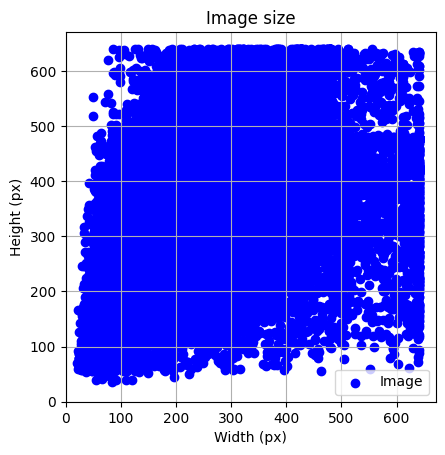

In [ ]:
# Tạo list là data để vẽ scatter plot (x, y)
data01 = [(image.shape[1], image.shape[0]) for image in all_image]
x01 = [point[0] for point in data01]
y01 = [point[1] for point in data01]
# Tạo plot
plt.scatter(x01, y01, label="Image", color="blue")
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.xlim(left=0)
plt.ylim(bottom=0)
# Đánh tên cho trục
plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.title("Image size")
plt.legend(loc="best")
# Hiện plot
plt.show()

In [ ]:
# Đổi biểu đồ scatter thành biểu đồ heatmap
# Chuẩn bị data để vẽ biểu đồ
x01_div50 = [x // 50 for x in x01]
y01_div50 = [y // 50 for y in y01]
data01_div50 = np.zeros((max(y01_div50) + 1, max(x01_div50) + 1))
for i in range(len(x01_div50)):
  data01_div50[y01_div50[i]][x01_div50[i]] += 1
x01_div50_labels = [(i+1)*50 for i in range(max(x01_div50) + 1)]
y01_div50_labels = [(i+1)*50 for i in range(max(y01_div50) + 1)]

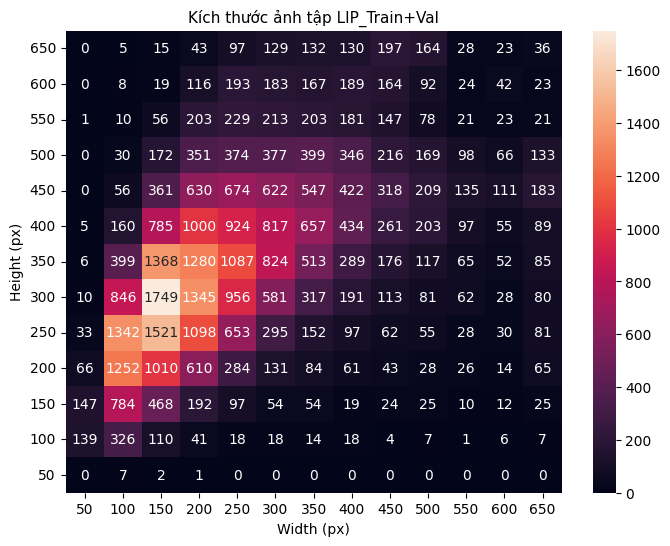

In [ ]:
plt.figure(figsize=(8,6))
# Vẽ biểu đồ heatmap
hm = sns.heatmap(data=data01_div50, xticklabels=x01_div50_labels,
                 yticklabels=y01_div50_labels, annot=True, fmt='g')
hm.invert_yaxis()
# Đánh tên cho trục
plt.xlabel("Width (px)", fontsize=10)
plt.ylabel("Height (px)", fontsize=10)
plt.title("Kích thước ảnh tập LIP_Train+Val", fontsize=11)
plt.yticks(rotation=0)
# Hiện biểu đồ
plt.show()

Các giá trị thống kê

In [ ]:
print("Width: [%d, %d]" % (min(x01), max(x01)))
print("Width Mean: %d" % (np.mean(np.array(x01))))
print("Width Variance: %d" % (np.var(np.array(x01))))
print("Width STD: %d" % (np.std(np.array(x01))))
print("Height: [%d, %d]" % (min(y01), max(y01)))
print("Height Mean: %d" % (np.mean(np.array(y01))))
print("Height Variance: %d" % (np.var(np.array(y01))))
print("Height STD: %d" % (np.std(np.array(y01))))


Width: [21, 640]
Width Mean: 230
Width Variance: 17515
Width STD: 132
Height: [36, 640]
Height Mean: 324
Height Variance: 14987
Height STD: 122


### 4.2 Thống kê số ảnh mỗi label

In [ ]:
# Find out semantic part labels in each image
image_unique_value = [np.unique(image) for image in all_image]
image_unique_value_count = [len(uv) for uv in image_unique_value]

# Đếm số ảnh có label được nhắc
img_per_label_count = [0] * len(label_names)
for image_uv in image_unique_value:
  for uv in image_uv:
    img_per_label_count[uv] += 1
# Phân loại màu cho tên label
label_is_human_part = [False, False, True, False, False, False, False, False,
                       False, False, False, False, False, True, True, True,
                       False, False, True, True]
plt02_color = [("red" if is_human_part else "blue") for is_human_part in label_is_human_part]

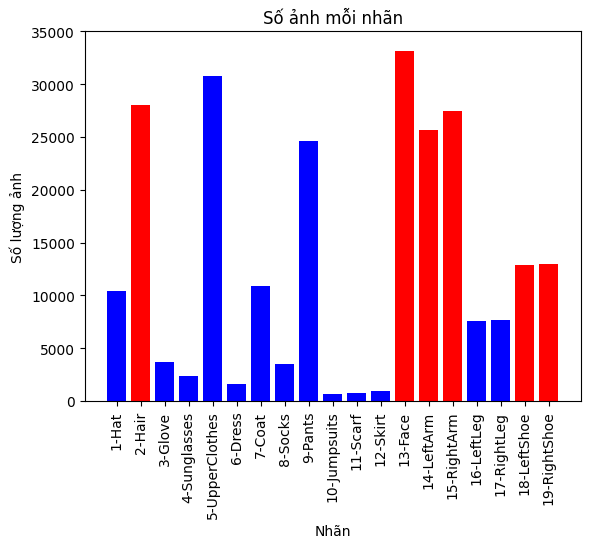

In [ ]:
# Tạo column chart
plt.bar(label_names[1:], img_per_label_count[1:], color=plt02_color[1:])
# Đánh tên cho trục
plt.xlabel("Nhãn")
plt.ylabel("Số lượng ảnh")
plt.title("Số ảnh mỗi nhãn")
plt.xticks(rotation=90)
plt.ylim(0,35000)
# Hiện plot
plt.show()

In [ ]:
# Tạo column chart được sắp xếp lại các cột theo nhóm màu
label_names_02, img_per_label_count_02, plt02_color_02 = ([], [], [])
sorter_idx = [10,11,12,6,4,8,3,16,17,1,7,9,5,13,2,15,14,19,18]
for i in range(len(sorter_idx)):
  label_names_02.append(label_names[sorter_idx[i]])
  img_per_label_count_02.append(img_per_label_count[sorter_idx[i]])
  plt02_color_02.append(plt02_color[sorter_idx[i]])

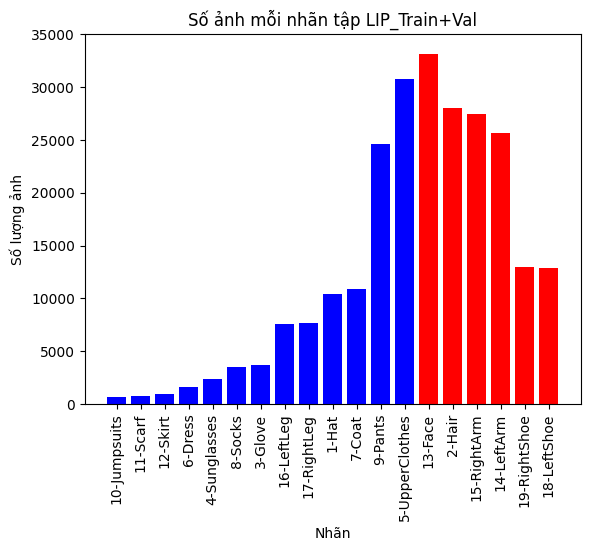

In [ ]:
# Tạo column chart
plt.bar(label_names_02, img_per_label_count_02, color=plt02_color_02)
# Đánh tên cho trục
plt.xlabel("Nhãn")
plt.ylabel("Số lượng ảnh")
plt.title("Số ảnh mỗi nhãn tập LIP_Train+Val")
plt.xticks(rotation=90)
plt.ylim(0,35000)
# Hiện plot
plt.show()

Thống kê theo tổng các nhãn

In [ ]:
# Không tính background
print(f"Miền giá trị: [{min(img_per_label_count[1:])}, {max(img_per_label_count[1:])}]")
print("Giá trị trung bình: %d" % (np.mean(np.array(img_per_label_count[1:]))))
print("Giá trị Variance: %d" % (np.var(np.array(img_per_label_count[1:]))))
print("Giá trị STD: %d" % (np.std(np.array(img_per_label_count[1:]))))

Miền giá trị: [690, 33183]
Giá trị trung bình: 12942
Giá trị Variance: 125700589
Giá trị STD: 11211


Tách đôi việc đếm số hình cho nhãn bộ phận người và nhãn quần áo

In [ ]:
img_per_label_is_human = []
img_per_label_not_human = []
for i, img_per_label in enumerate(img_per_label_count):
  if label_is_human_part[i]:
    img_per_label_is_human.append(img_per_label)
  else:
    img_per_label_not_human.append(img_per_label)

Thống kê theo nhãn bộ phận người

In [ ]:
print(f"Miền giá trị: [{min(img_per_label_is_human)}, {max(img_per_label_is_human)}]")
print("Giá trị trung bình: %d" % (np.mean(np.array(img_per_label_is_human))))
print("Giá trị Variance: %d" % (np.var(np.array(img_per_label_is_human))))
print("Giá trị STD: %d" % (np.std(np.array(img_per_label_is_human))))

Miền giá trị: [12895, 33183]
Giá trị trung bình: 23379
Giá trị Variance: 59572545
Giá trị STD: 7718


Thống kê theo nhãn trang phục

In [ ]:
# Không tính background
print(f"Miền giá trị: [{min(img_per_label_not_human[1:])}, {max(img_per_label_not_human[1:])}]")
print("Giá trị trung bình: %d" % (np.mean(np.array(img_per_label_not_human[1:]))))
print("Giá trị Variance: %d" % (np.var(np.array(img_per_label_not_human[1:]))))
print("Giá trị STD: %d" % (np.std(np.array(img_per_label_not_human[1:]))))

Miền giá trị: [690, 30789]
Giá trị trung bình: 8125
Giá trị Variance: 82742893
Giá trị STD: 9096


### 4.3 Thống kê số lượng ảnh có số lượng label tương ứng

In [ ]:
# Không tính background
label_array_uvc_no_bg = []
for i in range(len(image_unique_value_count)):
  label_array_uvc_no_bg.append(image_unique_value_count[i] - 1)
img_count_as_label_amount_no_bg = [0] * len(label_names)
for label_count in label_array_uvc_no_bg:
  img_count_as_label_amount_no_bg[label_count] += 1

In [ ]:
# for i, label_count in enumerate(image_unique_value_count):
#   if label_count == 1: print(i)

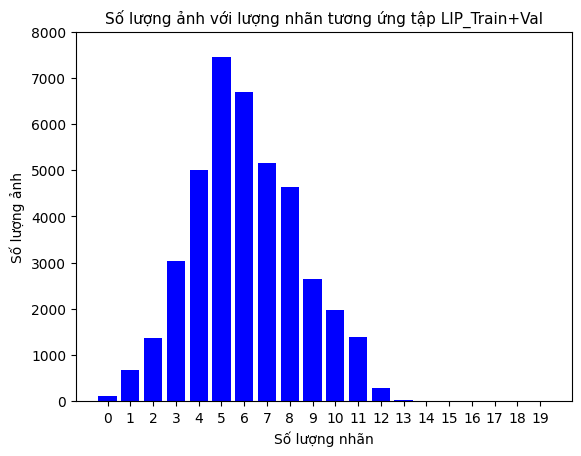

In [ ]:
# Tạo column chart
plt.bar(range(20), img_count_as_label_amount_no_bg, color="blue")
plt.xticks(range(20))
plt.ylim(0,8000)
# Đánh tên cho trục
plt.xlabel("Số lượng nhãn")
plt.ylabel("Số lượng ảnh")
plt.title("Số lượng ảnh với lượng nhãn tương ứng tập LIP_Train+Val", fontsize=11)

# Hiện plot
plt.show()

Chỉ số thống kê

In [ ]:
# Thống kê dựa trên số lượng nhãn
print(f"Range: [{min(label_array_uvc_no_bg)}, {max(label_array_uvc_no_bg)}]")
print("Mean: %0.1f" % (np.mean(np.array(label_array_uvc_no_bg))))
print("Variance: %0.1f" % (np.var(np.array(label_array_uvc_no_bg))))
print("STD: %0.1f" % (np.std(np.array(label_array_uvc_no_bg))))

Range: [0, 15]
Mean: 6.1
Variance: 5.5
STD: 2.4


### 4.4. Thống kê tỉ lệ nhãn bộ phận người và nhãn trang phục trên mỗi ảnh

In [ ]:
# Chuẩn bị data
human_label_per_img = [0] * len(all_image)
non_human_label_per_img = [0] * len(all_image)
for i, label_array in enumerate(image_unique_value):
  for label_idx in label_array:
    if label_is_human_part[label_idx]:
      human_label_per_img[i] += 1
    else:
      non_human_label_per_img[i] += 1
# Không tính background nên trừ bớt 1
for i in range(len(non_human_label_per_img)):
  non_human_label_per_img[i] -= 1
# Tạo ndarray data
data02 = np.zeros((max(non_human_label_per_img)+1, max(human_label_per_img)+1))
for i in range(len(human_label_per_img)):
  data02[non_human_label_per_img[i]][human_label_per_img[i]] += 1

In [ ]:
sum(sum(data02))

40462.0

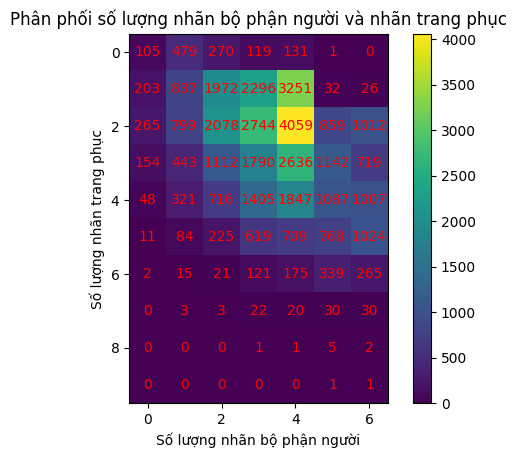

In [ ]:
# Tạo plot
plt.imshow(data02, interpolation='nearest')
plt.colorbar()
# Đánh tên cho trục
plt.xlabel("Số lượng nhãn bộ phận người")
plt.ylabel("Số lượng nhãn trang phục")
plt.title("Phân phối số lượng nhãn bộ phận người và nhãn trang phục")
# Đánh số lên heatmap
for i in range(data02.shape[0]):
  for j in range(data02.shape[1]):
    plt.annotate(str(int(data02[i][j])), xy=(j, i),
                     ha='center', va='center', color='red')
# Hiện plot
plt.show()

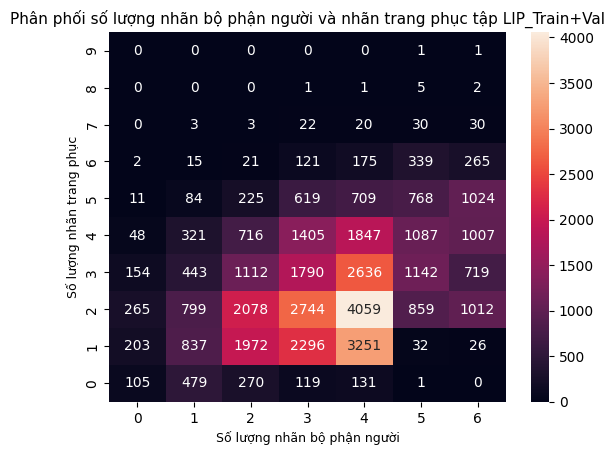

In [ ]:
hm = sns.heatmap(data=data02, annot=True, fmt='g')
hm.invert_yaxis()
# Đánh tên cho trục
plt.xlabel("Số lượng nhãn bộ phận người", fontsize=9)
plt.ylabel("Số lượng nhãn trang phục", fontsize=9)
plt.title("Phân phối số lượng nhãn bộ phận người và nhãn trang phục tập LIP_Train+Val", fontsize=11)
# Hiện biểu đồ
plt.show()

Thống kê số nhãn

In [ ]:
# Thống kê về số nhãn bộ phận người mỗi ảnh
print("Range: [%d, %d]" % (min(human_label_per_img), max(human_label_per_img)))
print("Mean: %.1f" % (np.mean(np.array(human_label_per_img))))
print("Variance: %.1f" % (np.var(np.array(human_label_per_img))))
print("STD: %.1f" % (np.std(np.array(human_label_per_img))))
# Thống kê về số nhãn quần áo mỗi ảnh
print("Range: [%d, %d]" % (min(non_human_label_per_img), max(non_human_label_per_img)))
print("Mean: %.1f" % (np.mean(np.array(non_human_label_per_img))))
print("Variance: %.1f" % (np.var(np.array(non_human_label_per_img))))
print("STD: %.1f" % (np.std(np.array(non_human_label_per_img))))

Range: [0, 6]
Mean: 3.5
Variance: 2.1
STD: 1.4
Range: [0, 9]
Mean: 2.6
Variance: 2.0
STD: 1.4


In [ ]:
data02

array([[1.050e+02, 4.790e+02, 2.700e+02, 1.190e+02, 1.310e+02, 1.000e+00,
        0.000e+00],
       [2.030e+02, 8.370e+02, 1.972e+03, 2.296e+03, 3.251e+03, 3.200e+01,
        2.600e+01],
       [2.650e+02, 7.990e+02, 2.078e+03, 2.744e+03, 4.059e+03, 8.590e+02,
        1.012e+03],
       [1.540e+02, 4.430e+02, 1.112e+03, 1.790e+03, 2.636e+03, 1.142e+03,
        7.190e+02],
       [4.800e+01, 3.210e+02, 7.160e+02, 1.405e+03, 1.847e+03, 1.087e+03,
        1.007e+03],
       [1.100e+01, 8.400e+01, 2.250e+02, 6.190e+02, 7.090e+02, 7.680e+02,
        1.024e+03],
       [2.000e+00, 1.500e+01, 2.100e+01, 1.210e+02, 1.750e+02, 3.390e+02,
        2.650e+02],
       [0.000e+00, 3.000e+00, 3.000e+00, 2.200e+01, 2.000e+01, 3.000e+01,
        3.000e+01],
       [0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 5.000e+00,
        2.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00]])

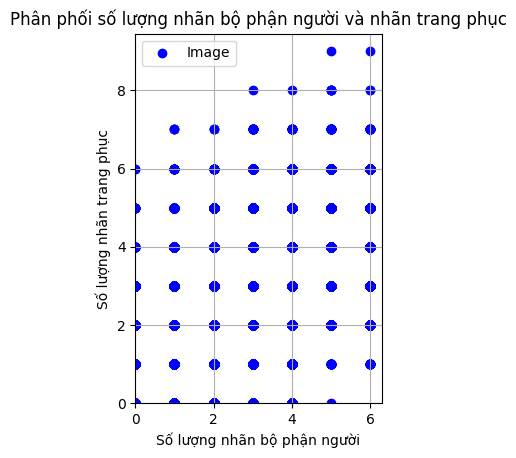

In [ ]:
# Tạo plot
plt.scatter(human_label_per_img, non_human_label_per_img, label="Image", color="blue")
plt.gca().set_aspect('equal', adjustable='box')
plt.grid()
plt.xlim(left=0)
plt.ylim(bottom=0)
# Đánh tên cho trục
plt.xlabel("Số lượng nhãn bộ phận người")
plt.ylabel("Số lượng nhãn trang phục")
plt.title("Phân phối số lượng nhãn bộ phận người và nhãn trang phục")
plt.legend(loc="best")
# Hiện plot
plt.show()